
# Demo: 1D Signal Decomposition and Wavelets

This notebook is adapted from your `Demo_1DSignalDecomposition.ipynb` and extended with
an extra interactive cell to display **low-pass and high-pass filter coefficients**
for different wavelets.

Pour une version interactive de ce notebook sur Binder:  
[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/joe-from-mtl/ele8812_Cours_AnalyseMultiresolution/master?filepath=notebooks%2FDemo_1DSignalDecomposition.ipynb)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 3

from ipywidgets import interactive, fixed
from scipy.interpolate import interp1d
import pywt



## Signal to decompose

\\[ f(x) = x^2, \text{ for } x \in [0, 1] \\]


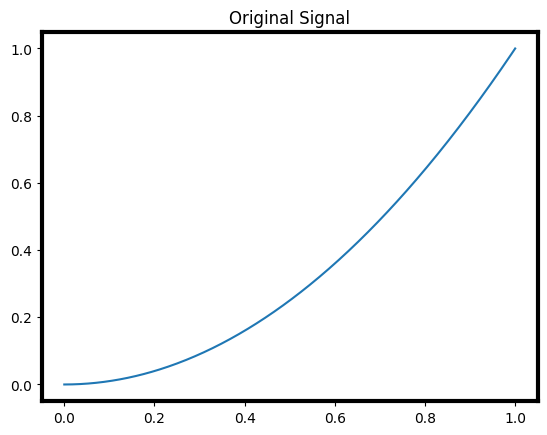

In [6]:

x = np.linspace(0, 1, 512)
y = x**2  # * np.cos(x*6.0*np.pi)
plt.plot(x, y)
plt.title('Original Signal')
plt.show()



## Signal series expansions

\\[ f(x) = \sum_k \alpha_k \phi_k(x) \\]

where \\(\\alpha_k\\) are *expansion coefficients*, \\(\\phi_k(x)\\) are *expansion functions*.

### Expansion coefficients

If \\(\\{\\phi_k(x)\\}\\) forms an orthonormal basis, the \\(\\alpha_k\\) are computed by taking the *integral inner product* of the basis \\(\\phi_k(x)\\) and function \\(f(x)\\):

\\[ \\alpha_k = \\langle\\phi_k(x), f(x)\\rangle = \\int\\phi^*_k(x) f(x) \\, dx \\]



## Example 1: Fourier Transform 1D

For the Fourier series expansion, the expansion functions are given by

\\[ \phi_k(x) = e^{2 i \pi k x / T} \\]


In [7]:

k = 4

def phi_fourier(x, k):
    phi = np.exp(2.0j * np.pi * k * x)
    return phi

def plot_fourier_functions(k):
    plt.figure(figsize=(8, 5))
    plt.plot(x, phi_fourier(x, k).real, label='Real part')
    plt.plot(x, phi_fourier(x, k).imag, label='Imaginary part')
    plt.title('Fourier basis function $\\phi_k(x)$ for k={}'.format(k), y=1.05)
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1]); plt.xlabel('x')
    plt.ylim([-1.5, 1.5]); plt.ylabel('y')
    plt.legend(loc=1)
    plt.show()

interactive(plot_fourier_functions, k=(0, 16))


interactive(children=(IntSlider(value=8, description='k', max=16), Output()), _dom_classes=('widget-interact',…


## Compute the expansion coefficients


In [12]:

coeffs = dict()
nLevels = 10
for k in range(-nLevels, nLevels + 1):
    alpha = np.sum(y * np.conj(phi_fourier(x, k)))
    coeffs['a_{}'.format(k)] = alpha

def plot_reconstruction_fourier(x, y, coeffs, max_level=-1):
    if max_level == -1:
        max_level = (len(coeffs) - 1) // 2

    signal = None
    plt.figure(figsize=(8, 5))
    for k in range(-max_level, max_level + 1):
        alpha = coeffs[f'a_{k}']
        phi = alpha * phi_fourier(x, k) / float(len(x))
        if signal is None:
            signal = phi
        else:
            signal += phi

        # Only label the last component to avoid duplicate legend entries
        label = r'$\alpha_k \phi_k(x)$' if k == max_level else None
        plt.plot(x, phi.real, color=[0.2, 0.2, 1.0], alpha=0.5, label=label)

    plt.plot(x, y, color='k', label=r'$f(x)$')
    plt.plot(x, signal.real, color='r',
             label=r'$\frac{1}{N}\sum_k \alpha_k \phi_k(x)$')
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1])
    plt.xlabel('x')
    plt.legend()
    plt.title(r'$|k| \leq %d$' % max_level, y=1.04)
    plt.show()

interactive(plot_reconstruction_fourier, x=fixed(x), y=fixed(y), coeffs=fixed(coeffs), max_level=(0, nLevels))


interactive(children=(IntSlider(value=0, description='max_level', max=10), Output()), _dom_classes=('widget-in…


## Scaling Functions


In [14]:

def get_scalingFunction(a, b, wavelet='haar', nSupport=1):
    phi_0, psi_0, x_0 = pywt.DiscreteContinuousWavelet(wavelet).wavefun(level=8)
    f = interp1d(x_0, phi_0, kind='linear', fill_value=0, bounds_error=False)
    w = x_0[-1] - x_0[0]
    xmin = x_0[0] - nSupport * w
    xmax = x_0[-1] + nSupport * w
    nSteps = int((2 * nSupport + 1) * len(x_0))
    x = np.linspace(xmin, xmax, nSteps)
    phi = 2**(a / 2.0) * f(2**a * x - b)
    return phi, x

def display_scalingFunction(j_scale=0, k_translate=0, wavelet='haar'):
    phi, x = get_scalingFunction(j_scale, k_translate, wavelet)
    plt.fill_between(x, phi)
    plt.plot(x, phi, color='k')
    plt.axhline(0, color='k', alpha=0.5)
    plt.axvline(0, color='k', alpha=0.5)
    plt.title(r'$\varphi_{%d,%d}(x)$' % (j_scale, k_translate), y=1.05)

waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']
interactive(display_scalingFunction, j_scale=(0, 4), k_translate=(-10, 10), wavelet=waveletList)


interactive(children=(IntSlider(value=0, description='j_scale', max=4), IntSlider(value=0, description='k_tran…


## Wavelet functions


In [15]:

def get_waveletFunction(a, b, wavelet='haar', nSupport=1):
    phi_0, psi_0, x_0 = pywt.DiscreteContinuousWavelet(wavelet).wavefun(level=8)
    f = interp1d(x_0, psi_0, kind='linear', fill_value=0, bounds_error=False)
    w = x_0[-1] - x_0[0]
    xmin = x_0[0] - nSupport * w
    xmax = x_0[-1] + nSupport * w
    nSteps = int((2 * nSupport + 1) * len(x_0))
    x = np.linspace(xmin, xmax, nSteps)
    psi = 2**(a / 2.0) * f(2**a * x - b)
    return psi, x

def display_waveletFunction(j_scale=0, k_translate=0, wavelet='haar'):
    psi, x = get_waveletFunction(j_scale, k_translate, wavelet)
    plt.fill_between(x, psi)
    plt.plot(x, psi, color='k')
    plt.axhline(0, color='k', alpha=0.5)
    plt.axvline(0, color='k', alpha=0.5)
    plt.title(r'$\psi_{%d,%d}(x)$' % (j_scale, k_translate), y=1.05)

waveletList = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']
interactive(display_waveletFunction, j_scale=(0, 4), k_translate=(-10, 10), wavelet=waveletList)


interactive(children=(IntSlider(value=0, description='j_scale', max=4), IntSlider(value=0, description='k_tran…


## Example: Decomposition using the Haar Wavelet Basis

We consider

\\[ f(x) = \sum_{k} c_{j_0}(k) \varphi_{j_0,k}(x) + \sum_{j\geq j_0}\sum_{k} d_j(k)\psi_{j,k}(x) \\]

**Scaling coefficients**

\\[ c_{j_0}(k) = \langle f(x), \varphi_{j_0,k}(x)\rangle = \int f(x) \varphi^*_{j_0, k}(x) \, dx \\]

**Wavelet coefficients**

\\[ d_{j}(k) = \langle f(x), \psi_{j,k}(x)\rangle = \int f(x) \psi^*_{j, k}(x) \, dx \\]



## Original signal, and Haar scaling and wavelet functions


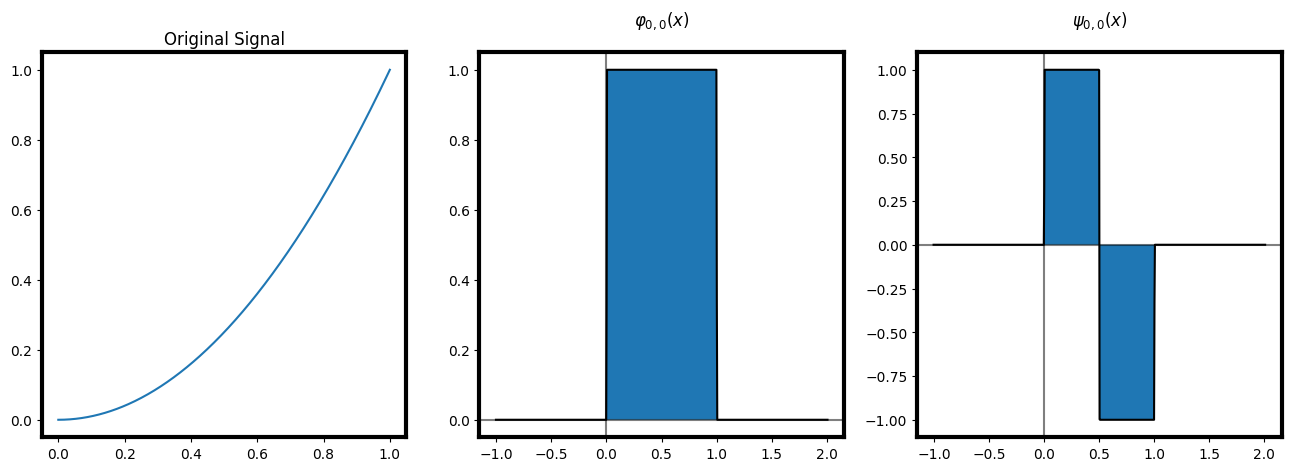

In [16]:

plt.figure(figsize=(16, 5))
j = 0; k = 0
plt.subplot(131); plt.plot(x, y); plt.title('Original Signal')
plt.subplot(132); display_scalingFunction(j, k)
plt.subplot(133); display_waveletFunction(j, k)
plt.show()



## Wavelet decomposition and reconstruction


In [17]:

def plot_reconstruction_haar(x, y, wavelet='haar', level=0):
    coeffs = pywt.wavedec(y, wavelet)
    plt.figure(figsize=(8, 5))
    coeffs_recons = []
    for k in range(len(coeffs)):
        if k > level + 1:
            coeffs_recons.append(np.zeros_like(coeffs[k]))
        else:
            coeffs_recons.append(coeffs[k])
    signal = pywt.waverec(coeffs_recons, wavelet)

    plt.plot(x, y, color='b', label=r'$f(x)$')
    plt.plot(x, signal, color='r',
             label=r'$\frac{1}{N}\sum_k \alpha_k \phi_k(x)$')
    plt.hlines(0, 0, 1, color='k', linewidth=2, linestyle='dashed')
    plt.xlim([0, 1])
    plt.xlabel('x')
    plt.legend()
    plt.title(r'$|j| \leq %d$' % level, y=1.04)
    plt.show()

waveletList = ['haar', 'db2', 'sym2']
interactive(plot_reconstruction_haar, x=fixed(x), y=fixed(y), level=(0, 8), wavelet=waveletList)


interactive(children=(Dropdown(description='wavelet', options=('haar', 'db2', 'sym2'), value='haar'), IntSlide…


## Wavelet filter coefficients (low-pass / high-pass)

The following interactive cell lets you inspect the **decomposition** and **reconstruction**
filter banks (low-pass and high-pass) for any discrete wavelet supported by PyWavelets.


In [20]:
from ipywidgets import interact

# Use the same wavelets as the scaling/wavelet function widgets
wavelet_subset = ['haar', 'db2', 'db3', 'db4', 'sym2', 'sym3']

def show_wavelet_filters(wavelet='haar'):
    w = pywt.Wavelet(wavelet)
    dec_lo, dec_hi, rec_lo, rec_hi = w.filter_bank

    print(f"Wavelet: {wavelet}")
    print("\nDecomposition low-pass (dec_lo):")
    print(np.array(dec_lo))
    print("\nDecomposition high-pass (dec_hi):")
    print(np.array(dec_hi))
    print("\nReconstruction low-pass (rec_lo):")
    print(np.array(rec_lo))
    print("\nReconstruction high-pass (rec_hi):")
    print(np.array(rec_hi))

    fig, axes = plt.subplots(2, 2, figsize=(10, 6))

    axes[0, 0].stem(dec_lo)
    axes[0, 0].set_title("Decomposition Low-pass")
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].stem(dec_hi)
    axes[0, 1].set_title("Decomposition High-pass")
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].stem(rec_lo)
    axes[1, 0].set_title("Reconstruction Low-pass")
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].stem(rec_hi)
    axes[1, 1].set_title("Reconstruction High-pass")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

interact(show_wavelet_filters, wavelet=wavelet_subset)


interactive(children=(Dropdown(description='wavelet', options=('haar', 'db2', 'db3', 'db4', 'sym2', 'sym3'), v…

<function __main__.show_wavelet_filters(wavelet='haar')>